In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/marco/Desktop/solar/OCAS_lib')
from OCAS_lib import Light, Calibration, Measurement
from scipy.signal import savgol_filter, find_peaks
import matplotlib.dates as md
from datetime import datetime
from scipy.optimize import curve_fit
from matplotlib import cm
from Normalization import Normalization
import matplotlib.patches as mpatches
import scipy.special as sc
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from datetime import datetime
now1 = datetime.now()


Loading data and atlas filenames

In [4]:
fD = "/home/marco/Desktop/solar/DATA/2020-09-22/drift_10mm/drift_10mm_2020-09-22_HR4D290.hdf"
fdD = "/home/marco/Desktop/solar/DATA/2020-09-22/darks150/darks150_2020-09-22_HR4D290.hdf"
fC = "/home/marco/Desktop/solar/DATA/2020-09-22/drift_10mm/drift_10mm_2020-09-22_HR4C5177.hdf"
fdC = "/home/marco/Desktop/solar/DATA/2020-09-22/darks150/darks150_2020-09-22_HR4C5177.hdf"
atsC = np.load("/home/marco/Desktop/solar/TemperatureProfile/mar/resampled_C.npy")
atsD = np.load("/home/marco/Desktop/solar/TemperatureProfile/mar/resampled_D.npy")


$I_\lambda = I_\nu \frac{c}{\lambda^2}$

In [5]:
c = 2.99792458e10
ats_lam_C = np.array(c/(atsC[0]*1e-7)**2 * atsC[1])
ats_lam_D = np.array(c/(atsD[0]*1e-7)**2 * atsD[1])

In [6]:
# OCAS-lib objects
mC = Light(fC,-2)
darkC = Calibration(fdC, 2)
mD = Light(fD,-2)
darkD = Calibration(fdD, 2)


In [7]:
# wavelength range shortcuts
wlc = mC.wl_range
wld = mD.wl_range

In [8]:
    print(np.average(np.diff(wld)))

0.123087778896


In [9]:
# linearity correction coefficients
def linccd(x, let):
	if let == "C":
		A = [0.952836,1.320268e-5,4.91468e-10,-7.415e-13,1.46495e-16,-1.40293e-20,6.72033e-25,-1.288e-29]
	if let == "D":
		A = [0.963663,6.6087e-6,5.63616e-9,-2.81251e-12,5.51632e-16,-5.48221e-20,2.71142e-24,-5.30629e-29]
	S = 0
	for i, a in enumerate(A):
		S += a*x**i
	return S

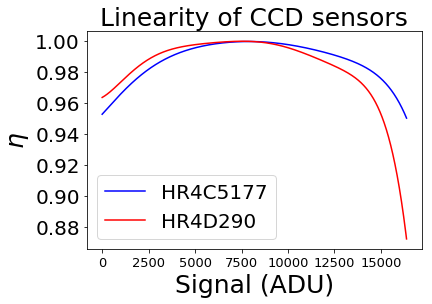

In [10]:
ADU_range = np.linspace(0,2**14-1,2**14)
plt.plot(ADU_range, linccd(ADU_range, "C"), c="b", label="HR4C5177")
plt.plot(ADU_range, linccd(ADU_range, "D"), c="r", label="HR4D290")


plt.title("Linearity of CCD sensors", fontsize=25)
plt.ylabel("$\eta$", fontsize=25)
plt.xlabel("Signal (ADU)", fontsize=25)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.savefig("Linearity.png", bbox_inches='tight', dpi=300)
plt.show()

In [11]:
def divide_linearity(x, let):
	A = x / linccd(x, let)
	return A

In [12]:
def linCor(data, let):
	R = data.shape[0]
	U = []
	for r in range(R):
		U.append(divide_linearity(data[r], let))
	return np.array(U)

In [13]:
UC = linCor(mC.data, "C")
UD = linCor(mD.data, "D")
# dark frame correction
masterdarkC = darkC.master
masterdarkD = darkD.master

DC = linCor(masterdarkC, "C")
DD = linCor(masterdarkD, "D")


mD.subtract_dark(masterdarkD)

dataC = UC- masterdarkC
dataD = UD - DD


# transposed measurements for later usage
dataTC = dataC.T
dataTD = dataD.T

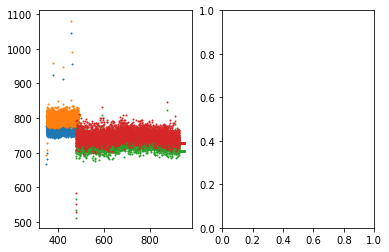

In [14]:
f, (a1,a2) = plt.subplots(1,2)
a1.scatter(wlc, masterdarkC,s=1)
a1.scatter(wlc, DC,s=1)

a1.scatter(wld, masterdarkD,s=1)
a1.scatter(wld, DD,s=1)



In [15]:
def disc_contact(integ):
	#dependent on scipy.signal module

	#taking a smoothed derivative
	#window size is tweakable
	windowsize = 15
	der = np.abs(savgol_filter(integ, windowsize, 1, 1))
	
	#initializing
	peaklenrange = []
	peakrange = []

	#initializing array of minimum derivative peak heights for the scipy.signal.find_peaks method
	#number_of_steps tweakable
	number_of_steps = 15
	X = np.linspace(0, np.max(der), number_of_steps)

	
	for min_peak in X:
		#find peaks above the treshold of i
		#returns an array of x-positions
		peaks, _ = find_peaks(der, min_peak)
		
		#making an array of the number of peaks
		peaklenrange.append(len(peaks))

		#logging the peak lists
		peakrange.append(peaks)

	#conversion to np array
	peaklenrange = np.array(peaklenrange)
	peakrange = np.array(peakrange)

	#masking: if only two peaks found
	twopeaks = peaklenrange == 2
	a, b = peakrange[twopeaks][0]
	return (a,b)

In [16]:
# make an average over all wavelengths for determining contacts
avg_driftC = np.average(dataC, axis=1)
avg_driftD = np.average(dataD, axis=1)

# calculate the contacts of the aperture with the solar disc
# a, b are the index of the rows where the abs(derivative) is the 
# hightest. This method is problematic, but ok within first approximation.
aC, bC = disc_contact(integ = avg_driftC)

aD, bD = disc_contact(integ = avg_driftD)
a, b = int((aC+aD)/2), int((bC+bD)/2)

aC and bC are much better predictors of real edge than aD and bD

In [17]:
aC, bC, aD, bD, a, b

(233, 1039, 229, 1038, 231, 1038)

In [18]:
def mu_converter(rows, a, b):
	#returns array of mu values, corresponding to the x-axis

	#init of a lin space with N elements
	row_range = np.linspace(0, rows, rows)
	
	#start and stop time, beggining of transit at r/R = -1, center = 0, end = 1
	r_range = ((row_range - a)/(b-a) - 0.5)*2

	#makes a range of mu values. When invalid, nan.
	mu_range = np.sqrt(1-r_range**2)

	return mu_range

In [19]:
mu_rangeC = mu_converter(rows = mC.rows, a=aC, b=bC)
mu_rangeD = mu_converter(rows = mD.rows, a=aC, b=bC)
centerC = mu_rangeC > 0.998
centerD = mu_rangeD > 0.998

/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


50

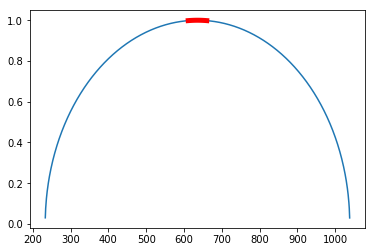

In [20]:
plt.plot(mC.row_range,mu_rangeC)
plt.plot(mC.row_range[centerC],mu_rangeC[centerC], c="r", linewidth=5)
np.sum(centerC)

In [21]:
def Gs(mu_range, y_data, center):
	#y_data can be integral data,
	#average data in a wavelenght-bin
	#or at a specific pixel
	#finding I_0, with which data shall be normalized
    
	I_0 = np.average(y_data[center])
	#normalized data: the G function
	Gs = y_data/I_0
	return Gs

In [22]:
def abc_fitter(Gs, mu_range):
	#masking NaNs
	mask = np.logical_not(np.isnan(mu_range))
	#fitting
	popt, pcov = curve_fit(phifit, mu_range[mask], Gs[mask])
	return popt

In [23]:
def phifit(mu, a, b, c):
	X = a + b*mu + c*(1 - mu*np.log(1 + 1/mu))
	return X

In [24]:
GC, GD = [], []
phiC, phiD = [], []

for drift in dataTC:
    G = Gs(mu_rangeC, drift, centerC)
    GC.append(G)
    phiC.append(np.array(abc_fitter(G, mu_rangeC)))

for drift in dataTD:
    G = Gs(mu_rangeD, drift, centerD)
    GD.append(G)
    phiD.append(np.array(abc_fitter(G, mu_rangeD)))

GC = np.array(GC)
GD = np.array(GD)
phiC = np.array(phiC)
phiD = np.array(phiD)

Constant term $a_\lambda$

(-0.5, 2)

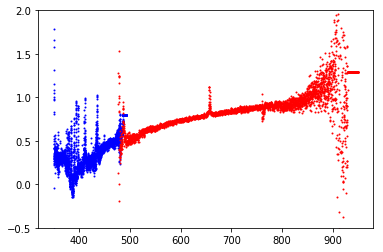

In [25]:
plt.scatter(wlc, phiC.T[0],s=1,c="b")
plt.scatter(wld, phiD.T[0],s=1,c="r")
plt.ylim(-0.5,2)

Linear term $b_\lambda$

(0, 1.1)

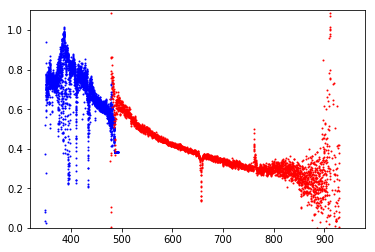

In [26]:
plt.scatter(wlc, phiC.T[1],s=1,c="b")
plt.scatter(wld, phiD.T[1],s=1,c="r")
plt.ylim(0,1.1)

Third term $c_\lambda$

(-1, 0.75)

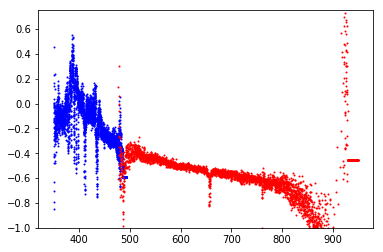

In [27]:
plt.scatter(wlc, phiC.T[2],s=1,c="b")
plt.scatter(wld, phiD.T[2],s=1,c="r")
plt.ylim(-1,0.75)

$$S_\nu (\mu, \lambda) = I_\nu^A(\mu=1) [a_\lambda + b_\lambda \mu + c_\lambda E_2 (\mu)]$$
$$S_\lambda (\mu, \lambda) = I_\lambda^A(\mu=1) [a_\lambda + b_\lambda \mu + c_\lambda E_2 (\mu)]$$

In [28]:
def S_abc(mu_range, wl_range, phi, ats):
	# S (mu, lam)
	Sm = np.zeros((mu_range.shape[0], wl_range.shape[0]))
	for l, lam in enumerate(wl_range):
		a, b, c = phi[l]
		for m,mu in enumerate(mu_range):
			if mu == np.nan:
				s = np.nan
			else:
				s = ats[l]*(a + b*mu + c * sc.expn(2, mu) )
			Sm[m][l] = s
	return Sm

jak vypadají fity Gs pomocí a,b,c na rozhraní spektrometrů na mu

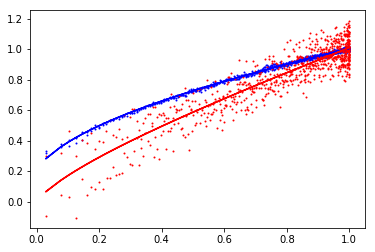

In [29]:
for k in [-50]:
    plt.scatter(mu_rangeC,GC[k],s=1,c="b")
    plt.plot(mu_rangeC,phifit(mu_rangeC,*phiC[k]),c="b")
    k = -k
    plt.scatter(mu_rangeD,GD[k],c="r",s=1)
    plt.plot(mu_rangeD,phifit(mu_rangeD,*phiD[k]),c="r")

In [30]:
S_nuC = S_abc(mu_rangeC, wlc, phiC, atsC[1])
S_nuD = S_abc(mu_rangeD, wld, phiD, atsD[1])
S_lamC = S_abc(mu_rangeC, wlc, phiC, ats_lam_C)
S_lamD = S_abc(mu_rangeD, wld, phiD, ats_lam_D)

Test for $\mu = \tau_\lambda \approx 1$

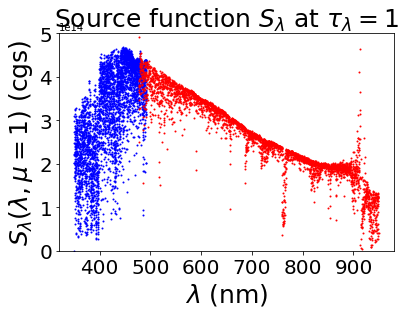

In [31]:
plt.scatter(wlc, np.average(S_lamC[centerC], axis=0), s=1, c="b")
plt.scatter(wld, np.average(S_lamD[centerD], axis=0), s=1, c="r")
#plt.ylim(0,0.00005)
plt.ylim(0,5e14)
plt.title("Source function $S_\lambda$ at $\\tau_\lambda = 1$", fontsize=25)
plt.ylabel("$S_\lambda (\lambda, \mu=1)$ (cgs)", fontsize=25)
plt.xlabel("$\lambda$ (nm)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("Source_lambda.png", bbox_inches='tight', dpi=300)
plt.show()

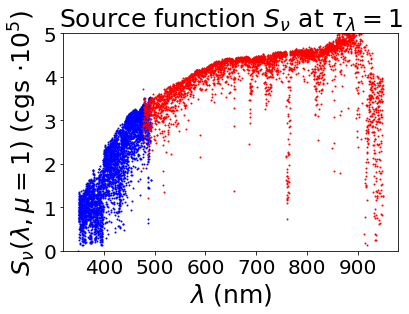

In [32]:
plt.scatter(wlc, np.average(S_nuC[centerC] * 1e5, axis=0), s=1, c="b")
plt.scatter(wld, np.average(S_nuD[centerD] * 1e5, axis=0), s=1, c="r")
plt.ylim(0,5)
plt.title("Source function $S_\\nu$ at $\\tau_\lambda = 1$", fontsize=25)
plt.ylabel("$S_\\nu (\lambda, \mu=1)$ (cgs $\cdot 10^5$)", fontsize=25)
plt.xlabel("$\lambda$ (nm)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("Source_nu.png", bbox_inches='tight', dpi=300)
plt.show()

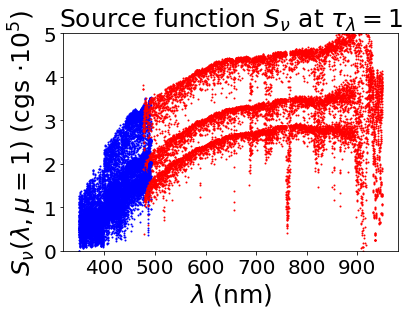

In [33]:
testmus = [1.0, 0.5, 0.3]
for testmu in testmus:
    plt.scatter(wlc, S_abc(np.array([testmu]), wlc, phiC, atsC[1])[0]* 1e5, c="b", s=1)
    plt.scatter(wld, S_abc(np.array([testmu]), wld, phiD, atsD[1])[0]* 1e5, c="r", s=1)
plt.ylim(0,5)
plt.title("Source function $S_\\nu$ at $\\tau_\lambda = 1$", fontsize=25)
plt.ylabel("$S_\\nu (\lambda, \mu=1)$ (cgs $\cdot 10^5$)", fontsize=25)
plt.xlabel("$\lambda$ (nm)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("Source_nu_various.png", bbox_inches='tight', dpi=300)
plt.show()

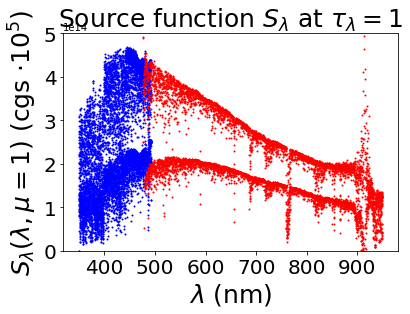

In [34]:
testmus = [1.0, 0.3]
for testmu in testmus:
    plt.scatter(wlc, S_abc(np.array([testmu]), wlc, phiC, ats_lam_C)[0], c="b", s=1)
    plt.scatter(wld, S_abc(np.array([testmu]), wld, phiD, ats_lam_D)[0], c="r", s=1)
plt.ylim(0,5e14)
plt.title("Source function $S_\\lambda$ at $\\tau_\lambda = 1$", fontsize=25)
plt.ylabel("$S_\lambda (\lambda, \mu=1)$ (cgs $\cdot 10^5$)", fontsize=25)
plt.xlabel("$\lambda$ (nm)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("Source_lam_various.png", bbox_inches='tight', dpi=300)
plt.show()

In [35]:
def temperature(wls, B):
	# assuming S (nu) == B (nu)
	# according to Placks law
	# in cgs units

	h = 6.6261e-27
	c = 2.99792458e10
	k = 1.3807e-16

	# converting the wavelength array to frequencies
	f = c/(wls*1e-7)

	# temperature expressed from Plancks law
	X = (2*h*f**3)/(c**2 * B) + 1

	A = (k * np.log( (2*h*f**3)/(c**2 * B) + 1 ))
	T = h*f / A

	return T

In [36]:
T_matrixC = temperature(mC.wl_range, S_nuC)
T_matrixD = temperature(mD.wl_range, S_nuD)

/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in divide
  
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


# Plot T(lambda) for the center of the disc

(5500, 6500)

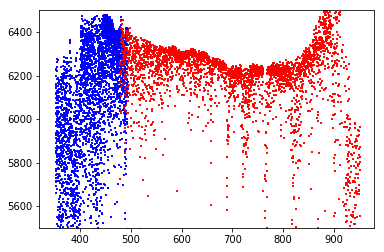

In [37]:
plt.scatter(wlc, np.average(T_matrixC[centerC], axis=0),s=1,c="b", marker=",")
plt.scatter(wld, np.average(T_matrixD[centerD], axis=0),s=1,c="r",marker=",")
plt.ylim(5500,6500)

T(lambda) for different mu

(5500, 6500)

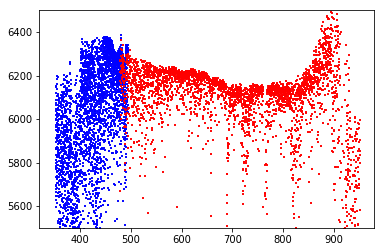

In [38]:
plt.scatter(wlc, T_matrixC[450],s=1,c="b", marker=",")
plt.scatter(wld, T_matrixD[450],s=1,c="r",marker=",")
plt.ylim(5500,6500)

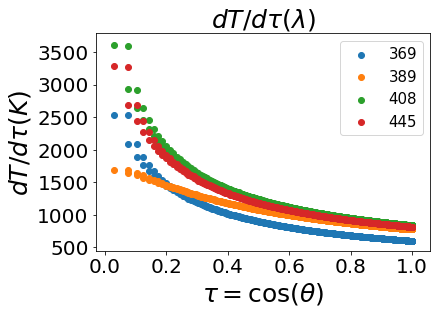

In [39]:
for lam in [500, 1000, 1500, 2500]:
    #plt.scatter(mu_rangeC, T_matrixC.T[lam],s=1, marker=",")
    plt.scatter(mu_rangeC[1:], np.diff(T_matrixC.T[lam])/np.diff(mu_rangeC), label=str(int(wlc[lam]) ))
plt.legend(fontsize=15)

plt.title("${dT}/{d\\tau} (\lambda)$", fontsize=25)
plt.ylabel("${dT}/{d\\tau} (K)$", fontsize=25)
plt.xlabel("$\\tau = \cos (\\theta)$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("dT_dtau_at_given_lambdaC.png", dpi=300)
plt.show()

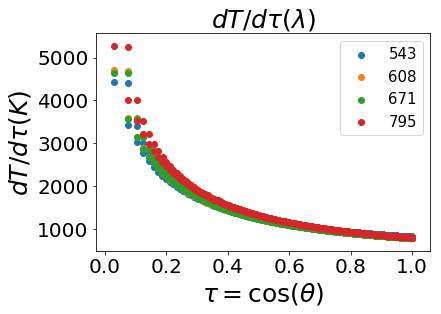

In [40]:
for lam in [500, 1000, 1500, 2500]:
    #plt.scatter(mu_rangeC, T_matrixC.T[lam],s=1, marker=",")
    plt.scatter(mu_rangeD[1:], np.diff(T_matrixD.T[lam])/np.diff(mu_rangeD), label=str(int(wld[lam]) ))
plt.legend(fontsize=15)

plt.title("${dT}/{d\\tau} (\lambda)$", fontsize=25)
plt.ylabel("${dT}/{d\\tau} (K)$", fontsize=25)
plt.xlabel("$\\tau = \cos (\\theta)$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("dT_dtau_at_given_lambdaD.png", dpi=300)
plt.show()

In [41]:
def D3_plotter(matC,matD, wlsC,wlsD, musC,musD):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for p in range(3,3840,100):
                if matC.T[600][-1] > 6000 or matD[600].all() > 5700:
                    pass
                else:
                    for r in range(3,1260,8):
                        muC = musC[r]
                        muD = musD[r]
                        lamC = wlsC[p]
                        lamD = wlsD[p]
                        MC = matC[r][p]
                        MD = matD[r][p]
                        ax.scatter(muC, lamC, MC, marker="o",s=1, color="b")
                        ax.scatter(muD, lamD, MD, marker="o",s=1, color="r")
    ax.set_zlim(5000, 6500)

    #plt.title("$S_\lambda (\mu)$", fontsize=20, pad=20)
    ax.set_ylabel("$\lambda$ (nm)", fontsize=10)
    ax.set_xlabel("$\mu$", fontsize=10)
    # ax.set_zlabel("$B_\lambda = S_\lambda (cgs)$", fontsize=20)
    ax.tick_params(labelsize=10)
    ax.invert_zaxis()
    plt.savefig("T_3dplot_reversed_2.png", bbox_inches='tight', dpi=300)
    ax.xaxis.labelpad=20
    ax.yaxis.labelpad=20
    ax.zaxis.labelpad=20

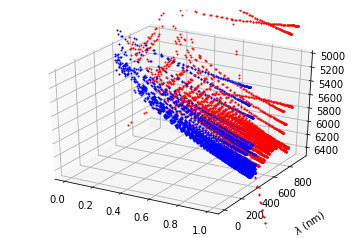

In [42]:
D3_plotter(T_matrixC,T_matrixD, wlc,wld, mu_rangeC,mu_rangeD)


In [43]:
def Sprime(mu_range, wl_range, phi, ats):
	# S (mu, lam)
	Sm = np.zeros((mu_range.shape[0], wl_range.shape[0]))
	for l, lam in enumerate(wl_range):
		a, b, c = phi[l]
		for m,mu in enumerate(mu_range):
			if mu == np.nan:
				s = np.nan
			else:
				s = ats[l]*( b - c * sc.expn(1, mu) )
			Sm[m][l] = s
	return Sm

$$S_\nu' (\mu, \lambda) = I_\nu^A(\mu=1) [a_\lambda + b_\lambda \mu + -c_\lambda E_1 (\mu)]$$
$$S_\lambda' (\mu, \lambda) = I_\lambda^A(\mu=1) [a_\lambda + b_\lambda \mu + -c_\lambda E_1 (\mu)]$$

In [44]:
S_lam_primeC = Sprime(mu_rangeC, wlc, phiC, ats_lam_C)
S_lam_primeD = Sprime(mu_rangeD, wld, phiD, ats_lam_D)

(0, 400000000000000.0)

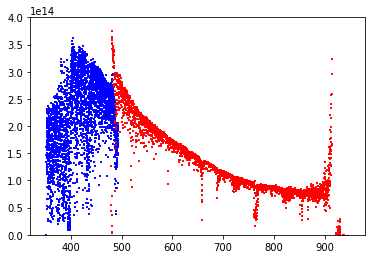

In [45]:
plt.scatter(wlc, S_lam_primeC[600],s=1,c="b", marker=",")
plt.scatter(wld, S_lam_primeD[600],s=1,c="r",marker=",")
plt.ylim(0,4e14)

(0, 400000000000000.0)

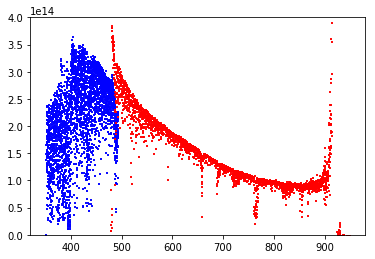

In [46]:
plt.scatter(wlc, S_lam_primeC[400],s=1,c="b", marker=",")
plt.scatter(wld, S_lam_primeD[400],s=1,c="r",marker=",")
plt.ylim(0,4e14)

(0, 400000000000000.0)

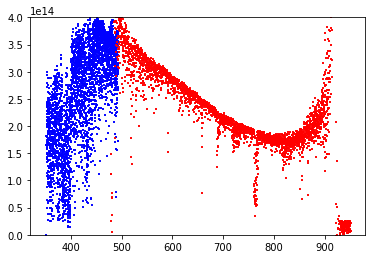

In [47]:
plt.scatter(wlc, S_lam_primeC[250],s=1,c="b", marker=",")
plt.scatter(wld, S_lam_primeD[250],s=1,c="r",marker=",")
plt.ylim(0,4e14)

# finding dS/dtau at given T

In [48]:

def Sprime_T(Sprime_matrix,T_matrix, t):
    # converting from S'(mu, lambda) -> S'(T, lambda)
    # using nearest indicies in the T(mu, lambda) matrix.
    nans = 0
    S_primes = [] 

    #iterating over wavelengths in the S' matrix
    for lam_idx, column in enumerate(Sprime_matrix.T):

        # sort indicies by difference from target temperature
        T_dif = np.abs(T_matrix.T[lam_idx] - t)
        
    
        # select a few closest maches
        mu_min_idx = np.argsort(T_dif)[:10]

        
        # 20 K range
        bottom = T_dif[mu_min_idx] > -10
        top = T_dif[mu_min_idx] < 10
        
        if bottom.sum() == mu_min_idx.size and top.sum() == mu_min_idx.size:
            avg_sprime = np.nanmean(column[mu_min_idx], axis=0)
        else:
            avg_sprime = np.nan
            nans+= 1

        S_primes.append(avg_sprime)

    S_primes = np.array(S_primes)
    return S_primes, nans

In [49]:
df = pd.read_csv("/home/marco/Desktop/solar/TemperatureProfile/mar/derivs.txt", delimiter="\t")

/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


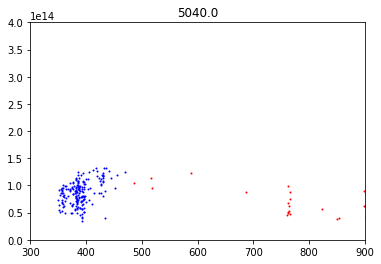

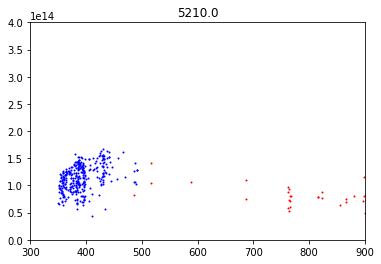

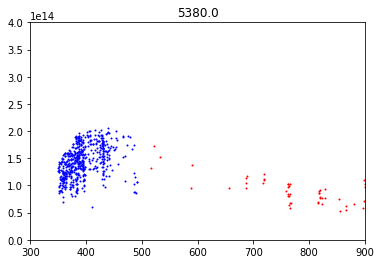

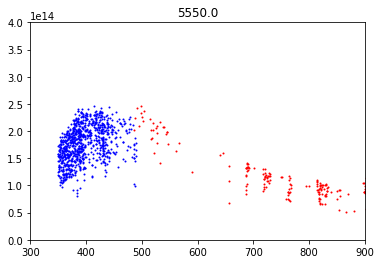

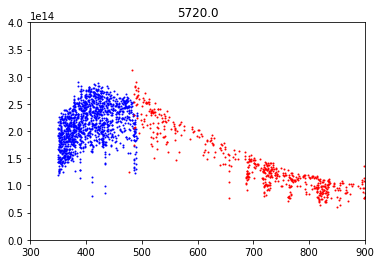

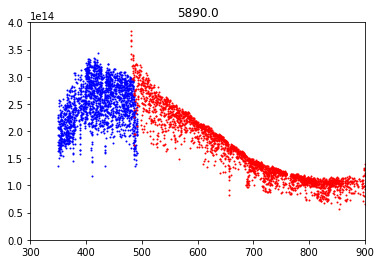

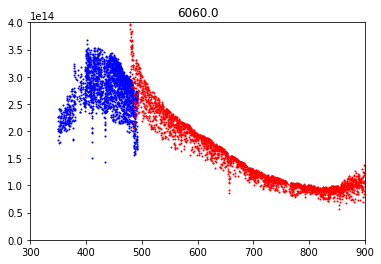

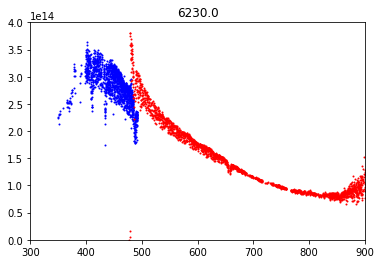

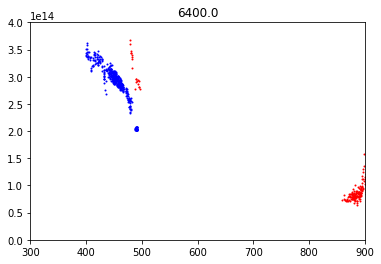

In [50]:
for T in np.linspace(5040, 6400, 9):
    SpT_lamC = Sprime_T(S_lam_primeC, T_matrixC, T)
    SpT_lamD = Sprime_T(S_lam_primeD, T_matrixD, T)
    plt.title(T)
    plt.scatter(wlc, SpT_lamC[0], c="b",s=1)
    plt.scatter(wld, SpT_lamD[0], c="r", s=1)
    plt.xlim(300, 900)
    plt.ylim(0,4e14)
    plt.show()

/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


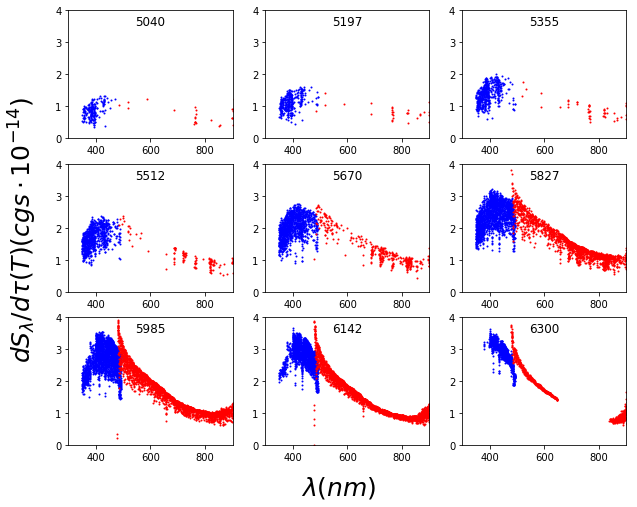

In [51]:
fig = plt.figure(figsize=(10,8))
a1 = fig.add_subplot(331)
a2 = fig.add_subplot(332)
a3 = fig.add_subplot(333)
a4 = fig.add_subplot(334)
a5 = fig.add_subplot(335)
a6 = fig.add_subplot(336)
a7 = fig.add_subplot(337)
a8 = fig.add_subplot(338)
a9 = fig.add_subplot(339)

As = [a1,a2,a3,a4,a5,a6,a7,a8,a9]
ts = np.linspace(5040, 6300, 9)

for i, a in enumerate(As):
    T = ts[i]
    SpT_lamC = Sprime_T(S_lam_primeC, T_matrixC, T)
    SpT_lamD = Sprime_T(S_lam_primeD, T_matrixD, T)
    a.set_title(int(T), pad=-15)
    a.scatter(wlc, SpT_lamC[0]*1e-14, c="b",s=1)
    a.scatter(wld, SpT_lamD[0]*1e-14, c="r", s=1)
    a.set_xlim(300, 900)
    a.set_ylim(0,4)


fig.text(0.5, 0.04, "$\lambda (nm)$",fontsize=25, ha='center')
fig.text(0.04, 0.5, "$dS_\lambda/d\\tau (T) (cgs \cdot 10^{-14})$",fontsize=25, va='center', rotation='vertical')

plt.savefig("S_prime_nine_plot.png", bbox_inches='tight', dpi=500)
plt.show()

In [52]:
def S_U(wl, T):
    h = 6.6261e-27
    c = 2.99792458e10
    k = 1.3807e-16
    c1 = 2*h*c**2
    c2 = h*c/k

    wl = wl*1e-7

    f = c/(wl)
    B = (2*h*f**3/c**2) * (np.expm1(h*f/(k*T))**(-1))

    Blam = (c1/wl**5) * (np.expm1(c2/(wl*T)))**(-1)
    U = 1 + (c1/wl**5)/Blam
    return Blam, U

(0, 500000000000000.0)

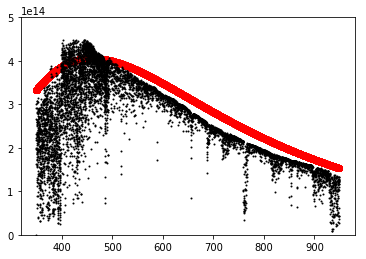

In [53]:
plt.scatter(wlc, S_U(wlc, 6300)[0], c="r")
plt.scatter(wld, S_U(wld, 6300)[0],c="r")


plt.scatter(wlc, ats_lam_C,s=1, c="k")
plt.scatter(wld, ats_lam_D,s=1,c="k")
plt.ylim(0,5e14)

Proč je teplota 6300 nejlepší fit? Co je vlastně teplota 5887K? Je to teplota v tau=0?

In [54]:
def dtau_dT(Sprime_matrix, T_matrix, t, wls):
    # find optical depth/temperature gradient
    # for a list of selected temperatures
    # in CGS units
    h = 6.6261e-27
    c = 2.99792458e10
    k = 1.3807e-16

    c1 = 2*h*c**2
    c2 = h*c/k


    S_primes = Sprime_T(Sprime_matrix, T_matrix, t)[0]
    # find S and U values for target temperature (from Planck's law)
    # this means S_nu
    S, U = S_U(wls, t)

    wls = wls * 1e-7
    # calculate opt. depth / temperature gradient
    grad = (1/S_primes) * (c2 / c1) * (wls**4 / t**2) * (S**2 * U)
    
    return np.array(grad)

John, 1990: Table 1.

In [55]:
df

,LAMBDA,1,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6
0,0.33,3.333,4.511,6.138,8.347,11.316,15.274,20.494,27.282,35.962
1,0.35,3.269,4.642,6.462,8.867,12.001,16.025,21.125,27.519,35.445
2,0.37,2.460,3.808,5.808,8.672,12.516,17.274,22.855,29.371,37.100
3,0.38,2.554,3.702,5.270,7.358,10.047,13.374,17.365,22.084,27.650
4,0.40,3.122,4.147,5.426,7.021,8.991,11.397,14.296,17.747,21.802
5,0.42,2.293,3.351,4.801,6.741,9.217,12.188,15.563,19.302,23.456
6,0.44,2.120,3.160,4.653,6.751,9.533,12.891,16.569,20.424,24.526
7,0.46,2.098,3.153,4.715,6.992,10.116,13.908,17.915,21.898,25.984
8,0.48,2.304,3.469,5.203,7.744,11.202,15.274,19.390,23.350,27.358
9,0.50,2.212,3.329,5.019,7.569,11.174,15.518,19.814,23.740,27.564


/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


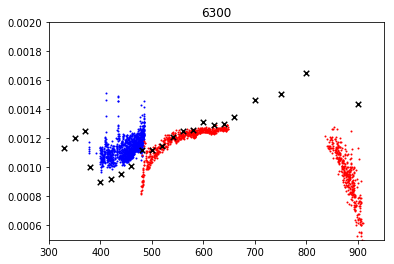

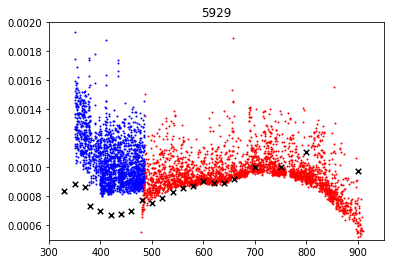

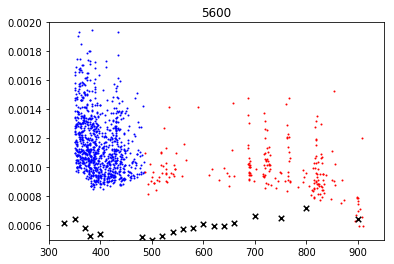

In [56]:
tcuts = df.keys()[1:]

#Ts = [5040/float(theta) for theta in tcuts]
thetas = np.array([0.8, 0.85, 0.9])
Ts = 5040/thetas



for i,theta in enumerate(thetas):
    t = Ts[i]
    plt.title(int(t))
    gradC = dtau_dT(S_lam_primeC, T_matrixC, t, wlc)
    gradD = dtau_dT(S_lam_primeD, T_matrixD, t, wld)
    plt.scatter(wlc[:-200],gradC[:-200],s=1,c="b")
    plt.scatter(wld,gradD,s=1,c="r")
    plt.scatter(df['LAMBDA']*1e3, df[str(theta)]*1e-4, s=30,marker="x",c="k")
    plt.ylim(0.0005,0.002)
    plt.xlim(300, 950)
    #plt.savefig("dtau_dT_at_0.8.png", bbox_inches='tight', dpi=200)
    plt.show()



(0.0006, 0.001)

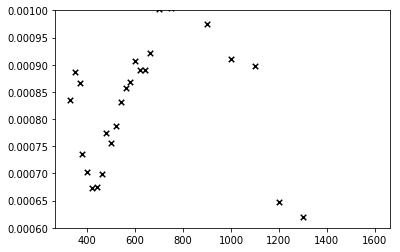

In [147]:
plt.scatter(df['LAMBDA']*1e3, df["0.85"]*1e-4, s=30,marker="x",c="k")
plt.ylim(0.0006,0.001)


In [57]:
falc = pd.read_csv("falcDat.txt", delimiter="\t")
falc

,height,tau_500,colmass,temp,v_turb,n_Htotal,n_proton,n_electron,pressure,p_gas/p,density
0,2218.20,0.000000e+00,0.000007,100000,11.73,5.580000e+09,5.580000e+09,6.670000e+09,0.186,0.952,1.310000e-14
1,2216.50,7.700000e-10,0.000007,95600,11.65,5.840000e+09,5.840000e+09,6.950000e+09,0.186,0.950,1.370000e-14
2,2214.89,1.530000e-09,0.000007,90816,11.56,6.150000e+09,6.150000e+09,7.280000e+09,0.186,0.948,1.440000e-14
3,2212.77,2.600000e-09,0.000007,83891,11.42,6.670000e+09,6.670000e+09,7.830000e+09,0.186,0.945,1.560000e-14
4,2210.64,3.750000e-09,0.000007,75934,11.25,7.380000e+09,7.380000e+09,8.580000e+09,0.186,0.941,1.730000e-14
5,2209.57,4.380000e-09,0.000007,71336,11.14,7.860000e+09,7.860000e+09,9.080000e+09,0.186,0.938,1.840000e-14
6,2208.48,5.070000e-09,0.000007,66145,11.02,8.490000e+09,8.480000e+09,9.720000e+09,0.186,0.935,1.990000e-14
7,2207.38,5.810000e-09,0.000007,60170,10.86,9.330000e+09,9.310000e+09,1.060000e+10,0.186,0.931,2.190000e-14
8,2206.27,6.640000e-09,0.000007,53284,10.67,1.050000e+10,1.050000e+10,1.180000e+10,0.186,0.925,2.470000e-14
9,2205.72,7.100000e-09,0.000007,49385,10.55,1.140000e+10,1.130000e+10,1.270000e+10,0.186,0.921,2.660000e-14


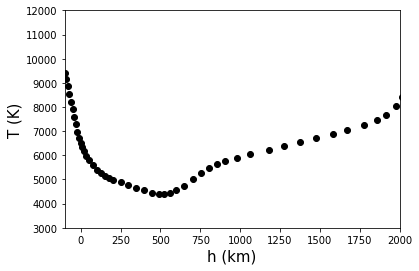

In [58]:
plt.scatter(falc["height"], falc["temp"],c="k")
plt.xlim(-100, 2000)
plt.ylim(3000, 12000)
plt.ylabel("T (K)", fontsize=15)
plt.xlabel("h (km)", fontsize=15)
plt.savefig("falc_T_vs_h.png", bbox_inches='tight', dpi=200)

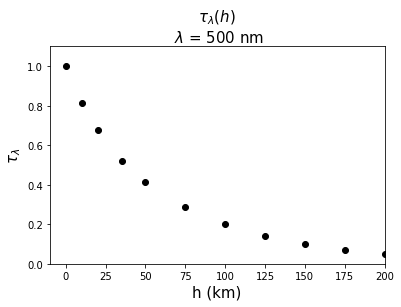

In [59]:
plt.scatter(falc["height"], falc["tau_500"],c="k")
plt.xlim(-10, 200)
plt.ylim(0,1.1)
plt.title("$\\tau_\lambda (h)$ \n $ \lambda$ = 500 nm", fontsize=15)
plt.ylabel("$\\tau_\lambda$", fontsize=15)
plt.xlabel("h (km)", fontsize=15)
plt.savefig("falc_tau_vs_h.png", bbox_inches='tight', dpi=200)

In [60]:
np.argmin(np.abs(wld - 500)) 

174

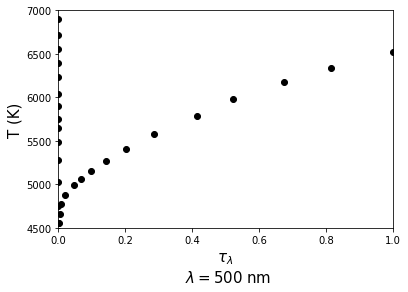

In [61]:
plt.scatter(falc["tau_500"], falc["temp"], c="k")
plt.xlim(0.001, 1)
plt.ylim(4500, 7000)
plt.ylabel("T (K)", fontsize=15)
plt.xlabel("$\\tau_\lambda$ \n $\lambda = 500$ nm", fontsize=15)
plt.savefig("falc_T_vs_tau.png", bbox_inches='tight', dpi=200)

zkusit s vlastníma měřeníma

/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(498.81812469859813, 501.47058113004596)
[ nan  nan  nan ...,  nan  nan  nan]
96.5301183084
1.48507874321
0.0384615384615


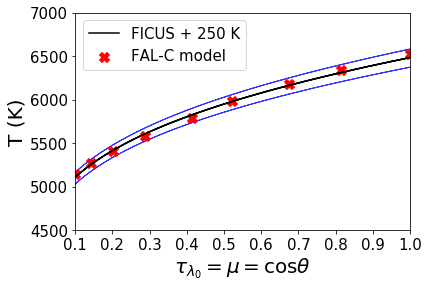

In [126]:
temps = np.nanmean(T_matrixD.T[165:185],axis=0)
sigma = np.nanstd(T_matrixD.T[165:185],axis=0)

print(wld[165],wld[185])
print(sigma)

SIG = np.nanmean(sigma)

fig, ax = plt.subplots()

ax.plot(mu_rangeD,temps + 250, c="k", label="FICUS + 250 K")


ax.fill_between(mu_rangeD, (temps-sigma + 250), (temps+sigma + 250),color="b",interpolate=True, alpha=0.8)



ax.scatter(falc["tau_500"], falc["temp"], c="r", marker="X", s=100, label="FAL-C model")
ax.set_xlim(0.1, 1)
ax.set_ylim(4500, 7000)
plt.ylabel("T (K)", fontsize=20)
plt.xlabel("$\\tau_{\lambda_0} = \mu = \cos \\theta$",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig("FALC4.png", bbox_inches='tight', dpi=200)


print(SIG)
print(SIG / 65)
print(250 / 6500.0)

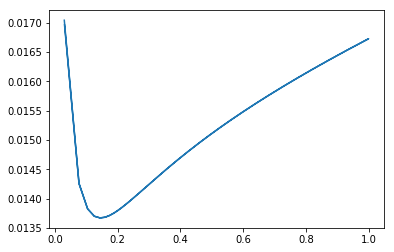

In [128]:
plt.plot(mu_rangeD, sigma/temps)

69
57


/usr/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


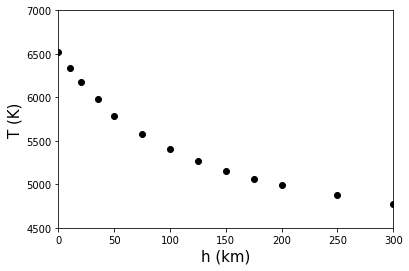

In [63]:
plt.scatter(falc["height"], falc["temp"],c="k")
plt.xlim(0, 300)
plt.ylim(4500, 7000)
plt.ylabel("T (K)", fontsize=15)
plt.xlabel("h (km)", fontsize=15)
print(np.argmin(np.abs(falc["height"] - 0)) )
print(np.argmin(np.abs(falc["height"] - 300)) )

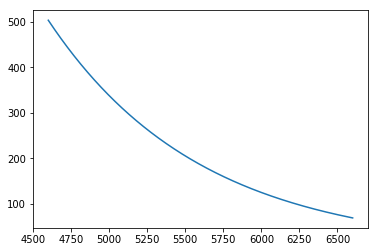

In [64]:
def falc_expfit(x, a, b,c):
    return a*np.exp(-b*x) + c
trange = np.linspace(4600, 6600, 1000)

ps = [5e4,0.001,1]

plt.plot(trange, falc_expfit(trange, *ps))

array([  7.29037221e+05,   1.62795340e-03,  -1.20937385e+01])

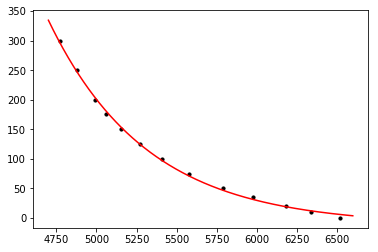

In [65]:
H_falc = falc["height"][57:70]
T_falc = falc["temp"][57:70]
trange = np.linspace(4700, 6600, 1000)



falc_popt, pcov = curve_fit(falc_expfit, T_falc, H_falc, bounds=([1e4,0.0005, -100],[10e5,0.002, 10]))

plt.scatter(T_falc, H_falc, s=10, c="k")

plt.plot(trange, falc_expfit(trange, *falc_popt), c="r")

falc_popt

/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


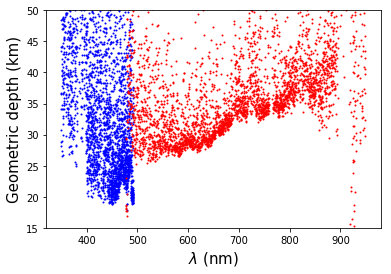

In [66]:
HCS = []
HDS = []
for i,mu in enumerate(mu_rangeD):
    if mu == np.nan:
        break
    else:
        HC = falc_expfit(T_matrixC[i], *falc_popt)
        HD = falc_expfit(T_matrixD[i], *falc_popt)
        HCS.append(HC)
        HDS.append(HD)
        
HCS = np.array(HCS)
HDS = np.array(HDS)

plt.scatter(wlc, np.nanmean(HCS,axis=0), s=1, c="b")
plt.scatter(wld, np.nanmean(HDS,axis=0), s=1, c="r")


plt.ylim(15, 50)
plt.ylabel("Geometric depth (km)", fontsize=15)
plt.xlabel("$\lambda$ (nm)",fontsize=15)

plt.savefig("Geom_depth.png", dpi=300,  bbox_inches='tight')


/usr/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(20, 60)

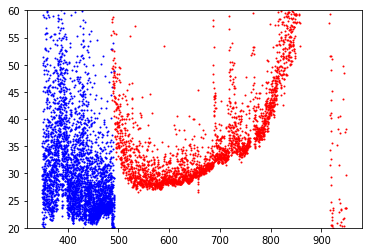

In [67]:
plt.scatter(wlc, np.nanstd(HCS,axis=0), s=1, c="b")
plt.scatter(wld, np.nanstd(HDS,axis=0), s=1, c="r")
plt.ylim(20,60)

In [68]:
t = 5929
#gradC = dtau_dT(S_lam_primeC, T_matrixC, t, wlc)
gradD = dtau_dT(S_lam_primeD, T_matrixD, t, wld)
gradC = dtau_dT(S_lam_primeC, T_matrixC, t, wlc)



A = np.nanmean(gradD[170:180])
s = np.nanstd(gradD[170:185])
print(A,s)


/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


(0.00092747045273249788, 0.00011286498021166502)


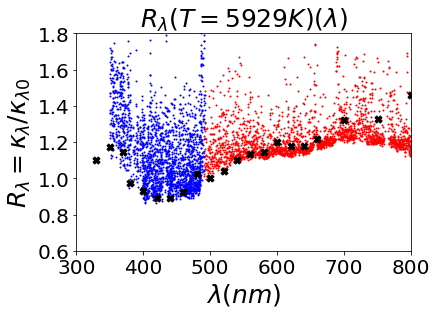

In [69]:

plt.ylim(0.6,1.8)
plt.xlim(300, 800)
plt.scatter(wld[100:-500],(gradD[100:-500] / A)+ 0.17,s=1, c="r")
plt.scatter(wlc,gradC / A,s=1,c="b")
plt.scatter(df["LAMBDA"] * 1000, df["0.85"]/df["0.85"][9], s=50,c="k", marker="X")
plt.title("$R_\lambda (T = 5929 K) (\lambda)$", fontsize=25)
plt.ylabel("$R_\lambda = \kappa_\lambda / \kappa_{\lambda 0}$", fontsize=25)
plt.xlabel("$\lambda (nm)$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("R_lambda_2.png", dpi=300,  bbox_inches='tight')
plt.show()


/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/marco/.local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


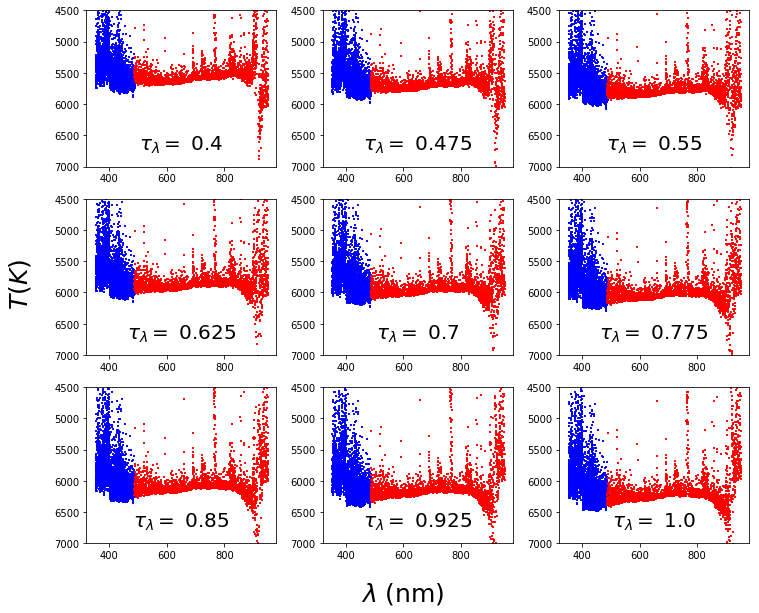

In [70]:
fig = plt.figure(figsize=(10,8))
a1 = fig.add_subplot(331)
a2 = fig.add_subplot(332)
a3 = fig.add_subplot(333)
a4 = fig.add_subplot(334)
a5 = fig.add_subplot(335)
a6 = fig.add_subplot(336)
a7 = fig.add_subplot(337)
a8 = fig.add_subplot(338)
a9 = fig.add_subplot(339)


def nearest_index(value, arr):
    #find the nearest index in an array of values
    # nan argmin necessary!!!
    idx = np.nanargmin(np.abs(arr-value))
    return idx

As = [a1,a2,a3,a4,a5,a6,a7,a8,a9]
muplt = np.linspace(0.4,1,9)

midx = [nearest_index(mu, mu_rangeD) for mu in muplt]

for i, a in enumerate(As):
    a.scatter(wlc[:-200],np.nanmean(T_matrixC[midx[i]-10:midx[i]+10],axis=0)[:-200], s=1, c="b",marker=",")
    a.scatter(wld[50:],np.nanmean(T_matrixD[midx[i]-10:midx[i]+10],axis=0)[50:], s=1, c="r", marker=",")
    
    a.set_ylim(4500,7000)
    a.set_title("$\\tau_\lambda =$ " + str(muplt[i]), pad=-140,fontsize=20)
    a.invert_yaxis()
    
fig.text(0.5, -0.05, "$\lambda$ (nm)",fontsize=25, ha='center')
fig.text(-0.05, 0.5, "$T (K)$",fontsize=25, va='center', rotation='vertical')
plt.tight_layout()  


plt.savefig("T_lambda_9.png", bbox_inches='tight', dpi=200)
plt.show()
